In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
import json
from glob import glob
import scipy.stats
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
'''Load calibration streamflow data'''
dt2 =pd.read_csv('Streamflow_daily.csv', 
                 parse_dates=['Date'])

# Coerce the data into the types specified in the metadata  
dt2.Watershed = dt2.Watershed.astype('category') 

# Pull out 2017 year
stream = dt2[(dt2.Date.dt.year > 2010) & (dt2.Date.dt.year < 2017)]
stream = stream[stream.Watershed == 'S2'].reset_index(drop = True)

#Convert cm/day to mm/sec
m = 10/(60*60*24)
stream['Flow_mms'] = m*stream['Flow (cm/day)']

'''Load calibration WTE data'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in the metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

# Pull out 2017 year
wte = dt1[(dt1.DATE.dt.year > 2010) & (dt1.DATE.dt.year < 2017)]
wte = wte[wte.PEATLAND == 'S2'].reset_index(drop = True)
#remove leap days
wte = wte[~((wte.DATE.dt.month == 2) & (wte.DATE.dt.day == 29))]
wte['WTD'] = -(422.0 - wte.WTE)

In [3]:
'''Read in data'''
#Uncalibrated data
SPRUCEuncalib = xr.open_mfdataset('ELM-SPRUCE/initRUN/TEST_US-SPR_ICB20TRCNPRDCTCBC/run/TEST_US-SPR_ICB20TRCNPRDCTCBC.clm2.h0.*-01-01-00000.nc', 
                            parallel = True)
CLMuncalib = xr.open_mfdataset('CLM5/derecho-nocalib/derecho_base_nocalib.clm2.h1.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEuncalib = xr.open_mfdataset('CLM-hillslope/3col-derecho-pure/hillslope-pure.clm2.h2.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEuncalibcol = xr.open_mfdataset('CLM-hillslope/3col-derecho-pure/hillslope-pure.clm2.h3.*-01-01-00000.nc', 
                            parallel = True)

#Calibrated Data
SPRUCEcalib = xr.open_mfdataset('ELM-SPRUCE/shiPARAMS/TESTShi2015_US-SPR_ICB20TRCNPRDCTCBC/TESTShi2015_US-SPR_ICB20TRCNPRDCTCBC.clm2.h0.*-01-01-00000.nc', 
                            parallel = True)
CLMcalib = xr.open_mfdataset('CLM5/derecho-lce-calib/testing_bayesopt_nobuild_derecho.clm2.h1.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEcalib = xr.open_mfdataset('CLM-hillslope/3col-derecho-lcecalib-medlynmods/hillslope-lce-calib-medlynslope.clm2.h2.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEcalibcol =  xr.open_mfdataset('CLM-hillslope/3col-derecho-lcecalib-medlynmods/hillslope-lce-calib-medlynslope.clm2.h3.*-01-01-00000.nc', 
                            parallel = True)

/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'gini' loading failed:
cannot import name 'deprecated' from 'typing_extensions' (/glade/work/marielj/conda-envs/ncdf/lib/python3.9/site-packages/typing_extensions.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
#history file with watsat
satDat = xr.open_mfdataset('/glade/derecho/scratch/marielj/archive/hillslope-wte-calib-seanmods/lnd/hist/hillslope-wte-calib-seanmods.clm2.h3.*-01-01-00000.nc', 
                            parallel = True)
satDat

<xarray.Dataset>
Dimensions:             (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1,
                         time: 5111, column: 3, hist_interval: 2, lndgrid: 1,
                         gridcell: 1, landunit: 1, pft: 15)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 1.0
  * time                (time) object 2004-01-01 00:00:00 ... 2018-01-01 00:0...
Dimensions without coordinates: column, hist_interval, lndgrid, gridcell,
                                landunit, pft
Data variables: (12/83)
    hillslope_distance  (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_width     (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_area      (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_elev      (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_slope     (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    hillslope_aspect    (time, column) float64 dask.array<chunksize=(365, 3), meta=np.ndarray>
    ...                  ...
    ZWT                 (time, column) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    ZWT_PERCH           (time, column) float32 dask.array<chunksize=(365, 3), meta=np.ndarray>
    TSOI                (time, levgrnd, column) float32 dask.array<chunksize=(365, 25, 3), meta=np.ndarray>
    watsat              (time, levgrnd, column) float32 dask.array<chunksize=(365, 25, 3), meta=np.ndarray>
    H2OSOI              (time, levsoi, column) float32 dask.array<chunksize=(365, 20, 3), meta=np.ndarray>
    SOILICE             (time, levsoi, column) float32 dask.array<chunksize=(365, 20, 3), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 02/17/25 13:47:10
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     day_1

In [5]:
'''Subset Timestamps'''
SPRUCEuncalib = SPRUCEuncalib.sel(time = slice("2011-01-01", "2016-12-31"))
CLMuncalib = CLMuncalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEuncalib = HILLSLOPEuncalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEuncalibcol = HILLSLOPEuncalibcol.sel(time = slice("2011-01-01", "2016-12-31"))

SPRUCEcalib = SPRUCEcalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEcalib = HILLSLOPEcalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEcalibcol = HILLSLOPEcalibcol.sel(time = slice("2011-01-01", "2016-12-31"))
CLMcalib = CLMcalib.sel(time = slice("2011-01-04", "2016-12-31"))

In [6]:
#Back calculate porosity estimates - can be replaced with watsat data later
HILLSLOPEcalibcol['H2OSOI_SAT'] = HILLSLOPEcalibcol.H2OSOI/satDat.watsat
HILLSLOPEcalibcol['H2OSOI_SAT'] = HILLSLOPEcalibcol.H2OSOI_SAT.isel(levgrnd = 0, drop = True)
HILLSLOPEcalibcol.H2OSOI_SAT

<xarray.DataArray 'H2OSOI_SAT' (time: 2190, levsoi: 20, column: 3)>
dask.array<getitem, shape=(2190, 20, 3), dtype=float32, chunksize=(365, 20, 3), chunktype=numpy.ndarray>
Coordinates:
  * levsoi   (levsoi) float32 0.01 0.04 0.09 0.16 0.26 ... 5.06 5.95 6.94 8.03
  * time     (time) object 2011-01-01 00:00:00 ... 2016-12-31 00:00:00
Dimensions without coordinates: column

## Hydraulic Redistribution

Text(0.0, 1.0, 'Upland')

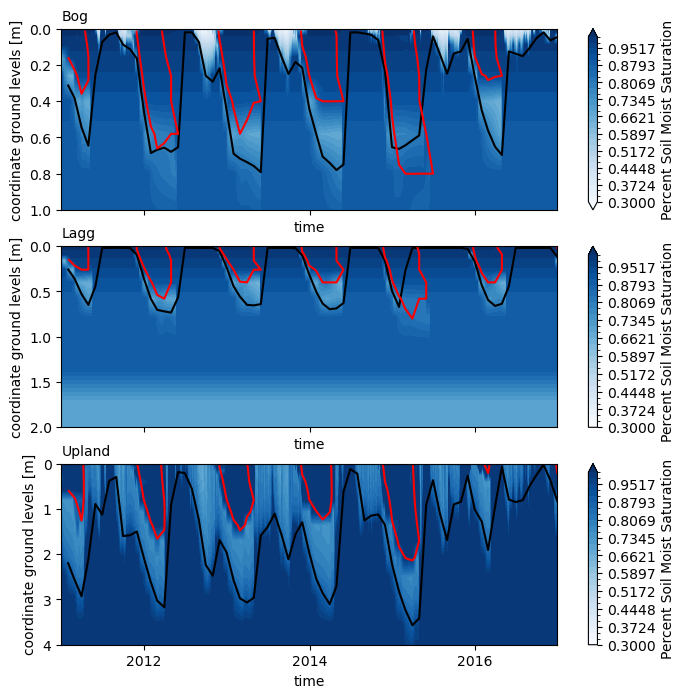

In [7]:
#Soil moisture for each model with overlayed observed water table
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize = (8, 8), 
                                   sharex = True)
HILLSLOPEcalibcol.H2OSOI_SAT.sel(column = 1).plot.contourf(x = 'time', y = 'levsoi',
                                            yincrease = False,
                                            cmap = 'Blues',
                                            levels = 30,
                                            cbar_kwargs = {'label' : 'Percent Soil Moist Saturation'}, 
                                            vmin = 0.3, vmax = 1,
                                            ax = ax1)
HILLSLOPEcalibcol.resample(time = 'M').mean().ZWT.sel(column = 1).plot(ax = ax1,
                                          color = 'black')
HILLSLOPEcalibcol.resample(time = 'M').mean().TSOI.sel(column = 1).plot.contour(x = 'time', y = 'levgrnd', 
                                                   yincrease = False, 
                                                   cmap = 'red', 
                                                   levels = [273.15],                       
                                                   ax = ax1)
#ax1.plot(HILLSLOPEcalibcol.H2OSOI_SAT.sel(column = 1).time, -wte.WTD, color = 'white')

ax1.set_ylim(1, 0)
ax1.set_title('Bog', loc = 'left', size = 10)

HILLSLOPEcalibcol.H2OSOI_SAT.sel(column = 0).plot.contourf(x = 'time', y = 'levsoi',
                                            yincrease = False,
                                            cmap = 'Blues',
                                            levels = 30,
                                            cbar_kwargs = {'label' : 'Percent Soil Moist Saturation'}, 
                                            vmin = 0.3, vmax = 1,
                                            ax = ax2)
HILLSLOPEcalibcol.resample(time = 'M').mean().ZWT.sel(column = 0).plot(ax = ax2,
                                          color = 'black')                        
HILLSLOPEcalibcol.resample(time = 'M').mean().TSOI.sel(column = 0).plot.contour(x = 'time', y = 'levgrnd', 
                                                   yincrease = False, 
                                                   cmap = 'red', 
                                                   levels = [273.15],                       
                                                   ax = ax2)
ax2.set_ylim(2, 0)
ax2.set_title('Lagg', loc = 'left', size = 10)

HILLSLOPEcalibcol.H2OSOI_SAT.sel(column = 2).plot.contourf(x = 'time', y = 'levsoi',
                                            yincrease = False,
                                            cmap = 'Blues',
                                            levels = 30,
                                            cbar_kwargs = {'label' : 'Percent Soil Moist Saturation'}, 
                                            vmin = 0.3, vmax = 1,
                                            ax = ax3)
HILLSLOPEcalibcol.resample(time = 'M').mean().ZWT.sel(column = 2).plot(ax = ax3,
                                          color = 'black')
HILLSLOPEcalibcol.resample(time = 'M').mean().TSOI.sel(column = 2).plot.contour(x = 'time', y = 'levgrnd', 
                                                   yincrease = False, 
                                                   cmap = 'red', 
                                                   levels = [273.15],                       
                                                   ax = ax3)
ax3.set_ylim(4, 0)
ax3.set_title('Upland', loc = 'left', size = 10)

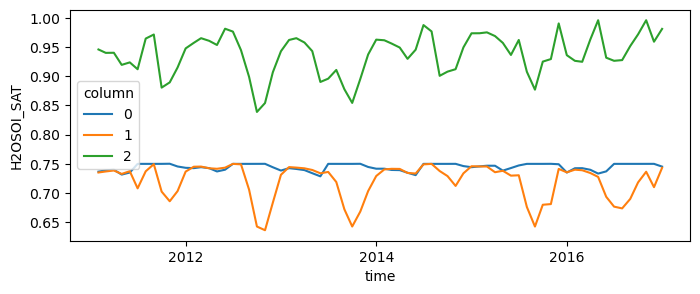

In [8]:
#Total column saturation
fig, ax = plt.subplots(1, 1, figsize = (8,3))

HILLSLOPEcalibcol.resample(time = 'M').mean().H2OSOI_SAT.mean(["levsoi"]).plot(hue = 'column', 
                                                                              ax = ax)

Text(0, 0.5, 'Delta Water Storage, kg/m3')

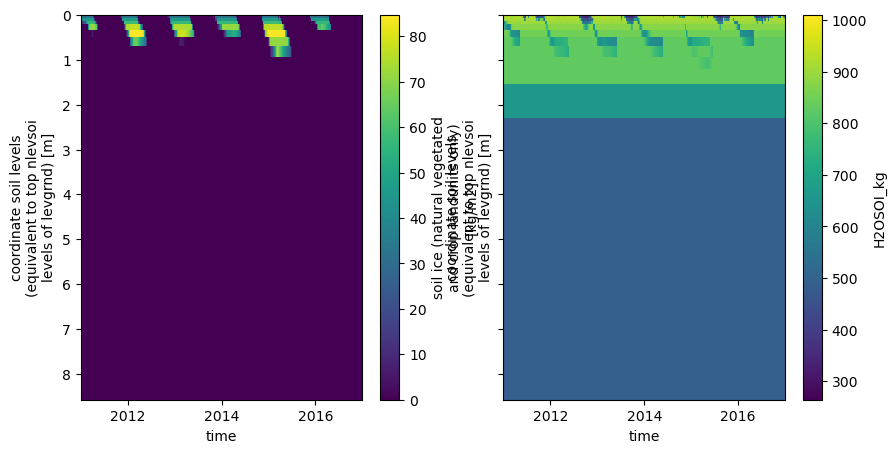

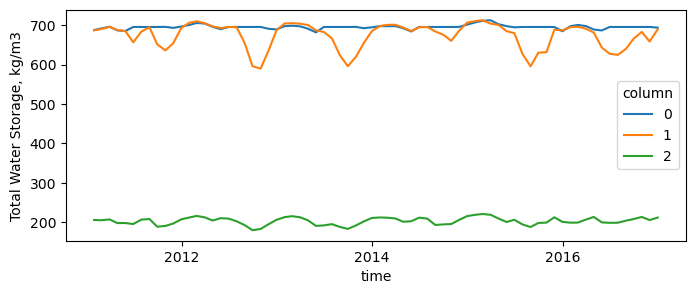

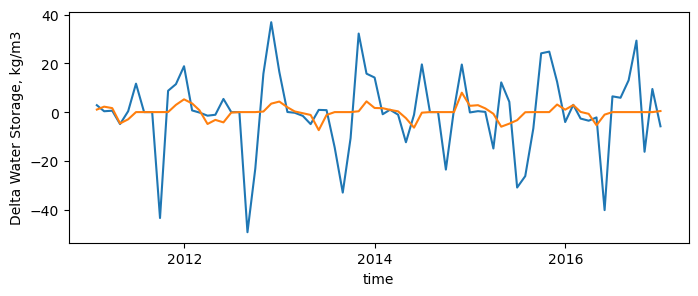

In [9]:
#Plot change in water storage in terms of soil moist and soil ice
#Transform soil water to weight (conservation of mass)
HILLSLOPEcalibcol['H2OSOI_kg'] = 1000*HILLSLOPEcalibcol.H2OSOI
HILLSLOPEcalibcol['TOTAL_S'] = HILLSLOPEcalibcol.H2OSOI_kg + HILLSLOPEcalibcol.SOILICE
fig, [ax, ax2] = plt.subplots(1, 2, figsize = (10, 5), 
                             sharex = True, 
                             sharey = True)

HILLSLOPEcalibcol.SOILICE.sel(column = 1).plot(x = 'time', y = 'levsoi',
                                                   yincrease = False,
                                                   ax = ax)
HILLSLOPEcalibcol.H2OSOI_kg.sel(column = 1).plot(x = 'time', y = 'levsoi',
                                                   yincrease = False,
                                                   ax = ax2)

#Redistribution
fig, ax = plt.subplots(1, 1, figsize = (8, 3))
HILLSLOPEcalibcol.resample(time = 'M').mean().TOTAL_S.mean(["levsoi"]).plot(hue = 'column', 
                                                                              ax = ax)
ax.set_ylabel("Total Water Storage, kg/m3")

#Storage transfer
fig, ax = plt.subplots(1, 1, figsize = (8, 3))
HILLSLOPEcalibcol.H2OSOI_kg.sel(column = 1).diff('time').sum('levsoi').resample(time = 'M').mean().plot(x = 'time',
                                                   ax = ax)

HILLSLOPEcalibcol.SOILICE.sel(column = 1).diff('time').sum('levsoi').resample(time = 'M').mean().plot(x = 'time',
                                                   ax = ax)
ax.set_ylabel("Delta Water Storage, kg/m3")

## Water Balance

In [10]:
monthly_precip = HILLSLOPEcalib.RAIN.resample(time = 'M').mean().values.flatten()
monthly_snow = HILLSLOPEcalib.SNOW.resample(time ='M').mean().values.flatten()
monthly_q = HILLSLOPEcalib.QRUNOFF.resample(time = 'M').mean().values.flatten()
monthly_E = HILLSLOPEcalib.QSOIL.resample(time = 'M').mean().values.flatten()
monthly_T = HILLSLOPEcalib.QVEGT.resample(time = 'M').mean().values.flatten()

#put together in dataframe
watBal = pd.DataFrame(data = {'Date': HILLSLOPEcalib.time.resample(time = 'M').min().values,
                       'P' : monthly_precip, 
                       'Snow' : monthly_snow, 
                       'Q' : monthly_q,
                       'E' : monthly_E, 
                       'Trans' : monthly_T})

Text(0, 0.5, 'Average Daily Inflow/Outflow, [mm/s]')

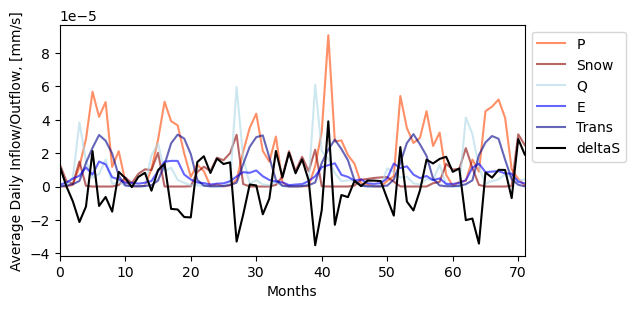

In [11]:
watBal['deltaS'] = watBal.P + watBal.Snow - watBal.Q - watBal.E - watBal.Trans

fig, ax = plt.subplots(1, 1, figsize = (6, 3))
#Ins
a = watBal.P.plot(color = 'orangered', alpha = 0.6, 
              ax = ax, legend = False)
b = watBal.Snow.plot(color = 'darkred', alpha = 0.6, 
                 ax = ax, legend = False)
#Outs
c = watBal.Q.plot(color = 'lightblue', alpha = 0.6, 
              ax = ax, legend = False)
d = watBal.E.plot(color = 'blue', alpha = 0.6, 
              ax = ax, legend = False)
e = watBal.Trans.plot(color = 'darkblue', alpha = 0.6, 
                  ax = ax, legend = False)
#Monthly change
f = watBal.deltaS.plot(color = 'black',
            ax = ax, legend = False)

ax.legend(bbox_to_anchor = (1, 1))
ax.set_xlim(0, 71)
ax.set_xlabel('Months')
ax.set_ylabel('Average Daily Inflow/Outflow, [mm/s]')

In [12]:
annual_precip = HILLSLOPEcalib.RAIN.resample(time = '12M').mean().values.flatten()
annual_snow = HILLSLOPEcalib.SNOW.resample(time ='12M').mean().values.flatten()
annual_q = HILLSLOPEcalib.QRUNOFF.resample(time = '12M').mean().values.flatten()
annual_E = HILLSLOPEcalib.QSOIL.resample(time = '12M').mean().values.flatten()
annual_T = HILLSLOPEcalib.QVEGT.resample(time = '12M').mean().values.flatten()

#put together in dataframe
watBal_annual = pd.DataFrame(data = {'Date': HILLSLOPEcalib.time.resample(time = '12M').min().values,
                       'P' : annual_precip, 
                       'Snow' : annual_snow, 
                       'Q' : annual_q,
                       'E' : annual_E, 
                       'Trans' : annual_T})
watBal_annual 

,Date,P,Snow,Q,E,Trans
0,2011-01-01 00:00:00,0.000000,0.000013,-5.180107e-23,0.000001,8.651045e-08
1,2011-02-01 00:00:00,0.000019,0.000003,7.766736e-06,0.000006,1.072288e-05
2,2012-02-01 00:00:00,0.000018,0.000007,6.080974e-06,0.000007,1.071624e-05
3,2013-02-01 00:00:00,0.000015,0.000009,7.440187e-06,0.000005,1.030493e-05
4,2014-02-01 00:00:00,0.000019,0.000005,9.948473e-06,0.000006,9.244138e-06
5,2015-02-01 00:00:00,0.000022,0.000004,4.688604e-06,0.000006,1.054041e-05
6,2016-02-01 00:00:00,0.000021,0.000009,1.045992e-05,0.000007,1.203183e-05


Text(0, 0.5, 'Average Daily Inflow/Outflow, [mm/s]')

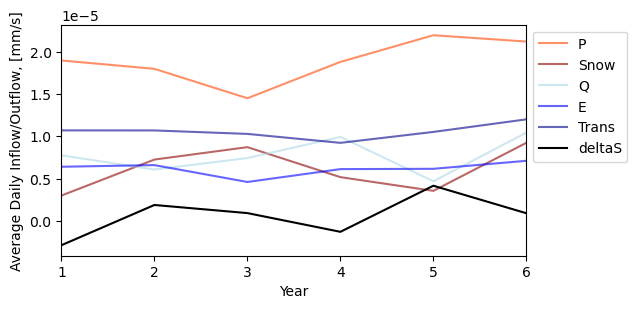

In [13]:
watBal_annual['deltaS'] = watBal_annual.P + watBal_annual.Snow - watBal_annual.Q - watBal_annual.E - watBal_annual.Trans

fig, ax = plt.subplots(1, 1, figsize = (6, 3))
#Ins
a = watBal_annual.P.plot(color = 'orangered', alpha = 0.6, 
              ax = ax, legend = False)
b = watBal_annual.Snow.plot(color = 'darkred', alpha = 0.6, 
                 ax = ax, legend = False)
#Outs
c = watBal_annual.Q.plot(color = 'lightblue', alpha = 0.6, 
              ax = ax, legend = False)
d = watBal_annual.E.plot(color = 'blue', alpha = 0.6, 
              ax = ax, legend = False)
e = watBal_annual.Trans.plot(color = 'darkblue', alpha = 0.6, 
                  ax = ax, legend = False)
#Monthly change
f = watBal_annual.deltaS.plot(color = 'black',
            ax = ax, legend = False)

ax.legend(bbox_to_anchor = (1, 1))
ax.set_xlim(1, 6)
ax.set_xlabel('Year')
ax.set_ylabel('Average Daily Inflow/Outflow, [mm/s]')